# ECBM 4040 - Assignment 1, Task 3: Dimensionality Reduction

Here is the third part and it is about dimentionality reduction. How to map high-dimentional data into low-dimensional space is an interesting topic in machine learning field. And also, it is related to another hot topic -- unsupervised learning. Now, in this section, you are going to learn two different methods for this question.

* Principal Component Analysis (PCA)
* t-Distributed Stochastic Neighbor Embedding (t-SNE) 

In [20]:
# Import modules
from __future__ import print_function
import tensorflow as tf
import numpy as np
import time
import matplotlib.pyplot as plt
from ecbm4040.cifar_utils import load_data

# Plot configurations
% matplotlib inline

# Notebook auto reloads code. (Ref: http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython)
% load_ext autoreload
% autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Data

We will use the CIFAR-10 dataset.

In [21]:
# Load the raw CIFAR-10 data.
X_train, y_train, X_test, y_test = load_data()
X_train = X_train.reshape([50000,3,32,32]).transpose((0,2,3,1))
X_test = X_test.reshape([10000,3,32,32]).transpose((0,2,3,1))
# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

# Data organizations:
# Train data: 49000 samples from original train set: 1~49000
# Validation data: 1000 samples from original train set: 49000~50000
# Test data: 10000 samples from original test set: 1~10000
# Development data (for gradient check): 100 from the train set: 1~49000 #TODOTA is this 100 or 1000?
num_training = 49000
num_validation = 1000
num_dev = 100

X_val = X_train[-num_validation:]
y_val = y_train[-num_validation:]

mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

X_train = X_train[:num_training]
y_train = y_train[:num_training]

# Preprocessing: subtract the mean value across every dimension for training data
mean_image = np.mean(X_train, axis=0)

X_train = X_train.astype(np.float32) - mean_image.astype(np.float32)
X_val = X_val.astype(np.float32) - mean_image
X_test = X_test.astype(np.float32) - mean_image
X_dev = X_dev.astype(np.float32) - mean_image

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('Development data shape:', X_dev.shape)
print('Development data shape', y_dev.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)
(49000, 32, 32, 3) (1000, 32, 32, 3) (10000, 32, 32, 3) (100, 32, 32, 3)
Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)
Development data shape: (100, 32, 32, 3)
Development data shape (100,)


## Part 1: Principal Component Analysis (PCA)

<span style="color:red"><strong>TODO</strong></span>: You have to complete the code in **./ecbm4040/features/pca.py**.

### Naive PCA

In [22]:
from ecbm4040.features.pca import pca_naive

X_patch = X_train[:,:,:,0]
X_patch = np.reshape(X_patch, (X_patch.shape[0], -1))

In [23]:
# Start PCA
K = 500
P, T = pca_naive(X_patch, K)

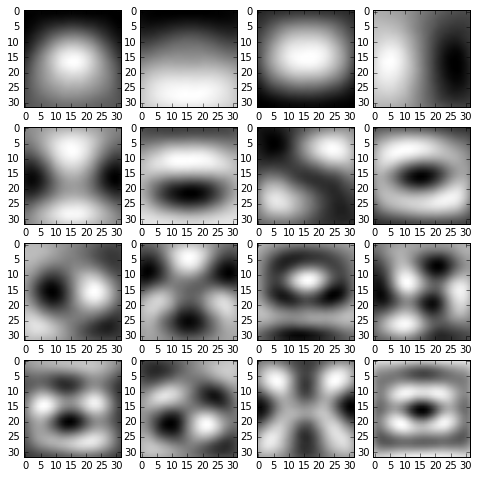

In [24]:
# TODO: Show principle components of P using a 4x4 subplot
# Visualize P
r = 4
f, axarr = plt.subplots(r, r, figsize=(8,8))
for i in range(r):
    for j in range(r):
        img = np.reshape(P[r*i+j], [32,32])
        axarr[i][j].imshow(img, cmap="gray")

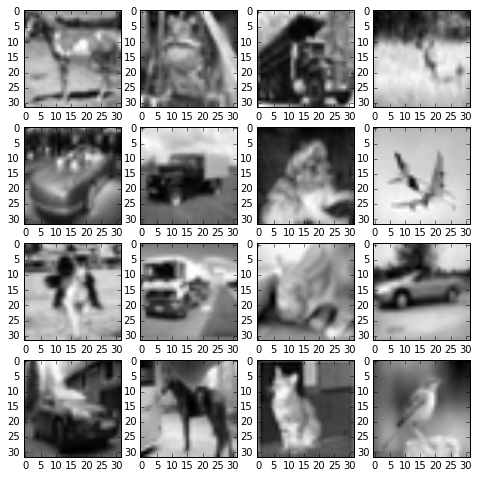

In [25]:
# Select a small set of images for test
num_training = 50000
num_pca = 16
mask = np.random.choice(num_training, num_pca, replace=False)
X_pca = X_train[mask,:,:,0]

# Visualize one channel of images 
r = 4
f, axarr = plt.subplots(r, r, figsize=(8,8))
for i in range(r):
    for j in range(r):
        img = X_pca[r*i+j]
        axarr[i][j].imshow(img, cmap="gray")

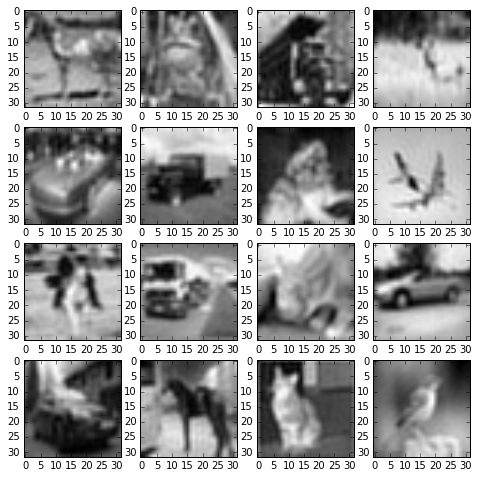

In [26]:
# TODO: Test your result
# Reduce dimension with P
X_features = []
for n in range(num_pca):
    img = X_pca[n]
    feature = np.dot(P, np.reshape(img, (-1,)))
    X_features.append(feature)

# Reconstruct image
X_recon = []
for n in range(num_pca):
    feature = X_features[n]
    img = np.reshape(np.dot(feature, P), (32,32))
    X_recon.append(img)

# Visualize results
r = 4
f, axarr = plt.subplots(r, r, figsize=(8,8))
for i in range(r):
    for j in range(r):
        img = X_recon[r*i+j]
        axarr[i][j].imshow(img, cmap="gray")

### PCA + Neural network

<span style="color:red"><strong>TODO</strong></span>: Use PCA to preprocess images before training a neural network: 

1. Do PCA preprocessing on each channel of the original image separately.
2. Stack PCA features from three channels into one vector, and use that vector as an input for MLP.
3. Train the MLP and show the results. 

In [27]:
from ecbm4040.train_funcs import train, test
from ecbm4040.classifiers.mlp import MLP

# TODO: pca preprocessing -> mlp classification

k = 500
num_channel = X_train.shape[-1]
PCA_comp = []
x_reshape = []
for i in range(num_channel):
    x_patch_ch = X_train[:,:,:,i]
    x_reshape_ch = np.reshape(X_patch, (X_patch.shape[0], -1))
    x_reshape.append(x_reshape_ch)
    P, T = pca_naive(x_reshape_ch, k)
    PCA_comp.append(P)

X_train_pca_list = []  
for i in range(num_channel):
    pca_feature_x = x_reshape[i].dot(PCA_comp[i].T)
    X_train_pca_list.append(pca_feature_x.dot(PCA_comp[i]))

X_train_pca = X_train_pca_list[0]
for i in range(1, num_channel):
    X_train_pca = np.append(X_train_pca, X_train_pca_list[i], axis = 1)


model = MLP(input_dim=3072, hidden_dims=[100,50,50], num_classes=10, reg=0.1, weight_scale=1e-3)

num_epoch = 10
batch_size = 500
lr = 1e-2
verbose = True
train_acc_hist, val_acc_hist = train(model, X_train_pca, y_train, X_val, y_val, 
                  num_epoch=num_epoch, batch_size=batch_size, learning_rate=lr, verbose=verbose)
test(model, X_test, y_test)


number of batches for training: 98
5000/49000 loss: 2.3076863317530454
10000/49000 loss: 2.3075301124596876
15000/49000 loss: 2.3073292478439447
20000/49000 loss: 2.3071070518651142
25000/49000 loss: 2.3068501334395664
30000/49000 loss: 2.3066017157443577
35000/49000 loss: 2.3063937608578065
40000/49000 loss: 2.3061203468486933
45000/49000 loss: 2.30586940574789
epoch 1: valid acc = 0.125, new learning rate = 0.0095
5000/49000 loss: 2.3053696848691527
10000/49000 loss: 2.3051586416055563
15000/49000 loss: 2.304894545441804
20000/49000 loss: 2.304674317066425
25000/49000 loss: 2.304427487609025
30000/49000 loss: 2.304239073199297
35000/49000 loss: 2.3041037689411055
40000/49000 loss: 2.3039086052016264
45000/49000 loss: 2.3037576332511227
epoch 2: valid acc = 0.128, new learning rate = 0.009025
5000/49000 loss: 2.303453541569732
10000/49000 loss: 2.303363071219037
15000/49000 loss: 2.3032376626766182
20000/49000 loss: 2.3031321632975
25000/49000 loss: 2.30303315673359
30000/49000 loss: 

0.10000000000000001

<span style="color:red"><strong>TODO</strong></span>: Plot training, validation and test set accuracy.

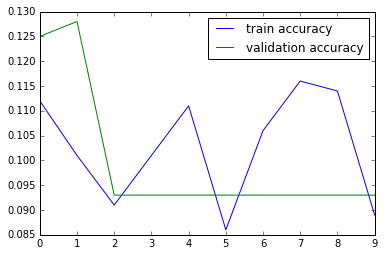

In [28]:
# TODO:
plt.plot(train_acc_hist, label="train accuracy")
plt.plot(val_acc_hist, label="validation accuracy")
plt.legend()
plt.show()

## Part 2: t-SNE (not graded)

t-SNE is is a machine learning algorithm for nonlinear dimensionality reduction developed by Geoffrey Hinton and Laurens van der Maaten. It is also a good way of visualizing high-dimensional data in 2D. We show its application for CIFAR10. Later it will be re-used in a CNN network. Experimenting with t-SNE can be fun. One thing to try is to visualize the output of each layer of MLP to observe the differences.

<p style="line-height: 1.2;">[1] Maaten, Laurens van der, and Geoffrey Hinton. "Visualizing data using t-SNE." Journal of Machine Learning Research 9.Nov (2008): 2579-2605.</p>
<p style="line-height: 1.2;">[2] Adaptive learning rate scheme by Jacobs https://www.willamette.edu/~gorr/classes/cs449/Momentum/deltabardelta.html</p>
<p style="line-height: 1.2;">[3] http://cs.stanford.edu/people/karpathy/cnnembed/</p>
<p style="line-height: 1.2;">[4] How to Use t-SNE Effectively, with examples.
 https://distill.pub/2016/misread-tsne</p>

In [29]:
from ecbm4040.features.tsne import tsne

#### tSNE of original data

In [30]:
random_select = np.random.choice(10000, 500, replace=False)
X = X_test[random_select,:,:,0].reshape(500,1024).astype('float')/255.0
tic = time.time()
Y = tsne(X, low_dim=2, perplexity=30.0)
print("it takes {} seconds".format(time.time()-tic))

2.55688477377
The 100 th loop cost: 14.861791897436785, computation time: 2.517416000366211
The 200 th loop cost: 1.1564150510493327, computation time: 5.200417757034302
The 300 th loop cost: 1.152673286984677, computation time: 7.757648944854736
The 400 th loop cost: 1.1526395335543123, computation time: 10.264388084411621
The 500 th loop cost: 1.152639487924948, computation time: 12.78384280204773
The 600 th loop cost: 1.1526394878630741, computation time: 15.299081802368164
The 700 th loop cost: 1.1526394878629673, computation time: 17.821510791778564
The 800 th loop cost: 1.1526394878629664, computation time: 20.39475154876709
The 900 th loop cost: 1.152639487862966, computation time: 23.08086061477661
The 1000 th loop cost: 1.1526394878629667, computation time: 25.603965997695923
it takes 26.716675758361816 seconds


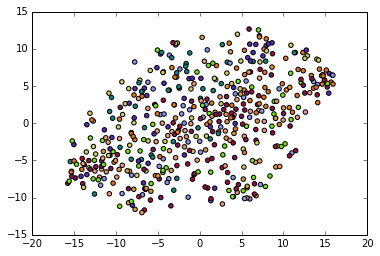

In [31]:
## visualize tSNE of original data
labels = y_test[random_select]
colors = np.random.rand(10,3)
color_labels = [colors[int(i)] for i in labels.tolist()]
plt.scatter(Y[:,0], Y[:,1], 20, color_labels)
plt.show()

#### tSNE of data after two hidden layers

In the visualization result, you should find that in comparison with the tSNE of original data where all data points mess up with each other, the tSNE of data after two-layer networks is shown as multiple clusters in a 2D panel.

In [32]:
# Define MLP model
model = MLP(input_dim=3072, hidden_dims=[100], num_classes=10, reg=0.1, weight_scale=1e-2)

num_epoch = 10
batch_size = 200
lr = 1e-3
verbose = False
train_acc_hist, val_acc_hist = train(model, X_train, y_train, X_val, y_val, 
                  num_epoch=num_epoch, batch_size=batch_size, learning_rate=lr, verbose=verbose)
test(model, X_test, y_test)

number of batches for training: 245
epoch 1: valid acc = 0.398, new learning rate = 0.00095
epoch 2: valid acc = 0.449, new learning rate = 0.0009025
epoch 3: valid acc = 0.459, new learning rate = 0.000857375
epoch 4: valid acc = 0.454, new learning rate = 0.0008145062499999999
epoch 5: valid acc = 0.443, new learning rate = 0.0007737809374999998
epoch 6: valid acc = 0.445, new learning rate = 0.0007350918906249997
epoch 7: valid acc = 0.442, new learning rate = 0.0006983372960937497
epoch 8: valid acc = 0.44, new learning rate = 0.0006634204312890621
epoch 9: valid acc = 0.414, new learning rate = 0.000630249409724609
epoch 10: valid acc = 0.422, new learning rate = 0.0005987369392383785
test acc: 0.4321


0.43209999999999998

In [33]:
# run tSNE
X = X_test[random_select]
X = model.layers[0].feedforward(X)
X = model.layers[1].feedforward(X)
X_exp = np.exp(X)
X = X_exp / np.tile(np.sum(X_exp, axis=1, keepdims=True), 10)

tic = time.time()
Y = tsne(X, low_dim=2, perplexity=30.0)
print("it takes {} seconds".format(time.time()-tic))

0.191345776571
The 100 th loop cost: 11.352704218779401, computation time: 2.775960683822632
The 200 th loop cost: 0.505824167184149, computation time: 5.870700120925903
The 300 th loop cost: 0.491362246369895, computation time: 9.544967651367188
The 400 th loop cost: 0.49027731572714134, computation time: 13.134938716888428
The 500 th loop cost: 0.4902061706651655, computation time: 16.23357582092285
The 600 th loop cost: 0.490199193433772, computation time: 19.349223375320435
The 700 th loop cost: 0.49019845786994476, computation time: 23.834212064743042
The 800 th loop cost: 0.49019837540948324, computation time: 26.53879451751709
The 900 th loop cost: 0.4901983663799814, computation time: 29.424880266189575
The 1000 th loop cost: 0.490198365372835, computation time: 32.930816650390625
it takes 34.4469735622406 seconds


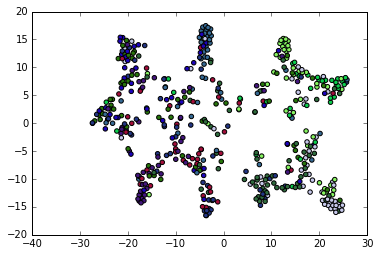

In [34]:
# visualize tSNE 2D representation of data after two hidden layers
labels = y_test[random_select]
colors = np.random.rand(10,3)
color_labels = [colors[int(i)] for i in labels.tolist()]
plt.scatter(Y[:,0], Y[:,1], 20, color_labels)
plt.show()